In [16]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

src_path = Path('/u/duvel-d2/govorcin/NJ/ASC/disp_xr_tools/disp_xr_tools/src')
sys.path.append(str(src_path))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import logging
logger = logging.getLogger('disp_xr')

# Configure basic logging
logger.setLevel(logging.INFO)  # Set logging level

# Create handler (console output)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)  # Set level for this handler

# Add handler to logger
logger.addHandler(handler)

# Prevent duplicate logs if the root logger already has handlers
logger.propagate = False


In [18]:
import disp_xr
from disp_xr import product, stack as disp_stack, utils, quality_metrics

In [19]:
# Get DISP version 0.9 data
disp_df = product.get_disp_info('/u/duvel-d2/govorcin/NJ/ASC/8622')

Found OPERA DISP: 254 products
Found OPERA DISP: 254 products
 Starting date: 2016-07-16 22:50:42
 Starting date: 2016-07-16 22:50:42
 Ending date: 2024-06-16 22:51:24
 Ending date: 2024-06-16 22:51:24
 Number of reference dates: 8
 Number of reference dates: 8
 Skip 30 duplicates
 Skip 30 duplicates


In [20]:
disp_df.head()

project level  product mode frame_id polarizarion          start_date  \
0   OPERA    L3  DISP-S1   IW   F08622           VV 2021-07-26 22:51:14   
1   OPERA    L3  DISP-S1   IW   F08622           VV 2022-07-21 22:51:19   
3   OPERA    L3  DISP-S1   IW   F08622           VV 2021-07-26 22:51:14   
4   OPERA    L3  DISP-S1   IW   F08622           VV 2021-07-26 22:51:14   
5   OPERA    L3  DISP-S1   IW   F08622           VV 2016-07-16 22:50:42   

             end_date version   production_date  \
0 2021-10-18 22:51:17    v0.9  20241225T003448Z   
1 2023-01-05 22:51:20    v0.9  20241227T103331Z   
3 2022-04-16 22:51:13    v0.9  20241225T213322Z   
4 2022-03-11 22:51:13    v0.9  20241225T213322Z   
5 2016-11-13 22:50:46    v0.9  20241219T225202Z   

                                                path             date12  \
0  /u/duvel-d2/govorcin/NJ/ASC/8622/products/OPER...  20210726_20211018   
1  /u/duvel-d2/govorcin/NJ/ASC/8622/products/OPER...  20220721_20230105   
3  /u/duvel-d2/govorcin/NJ/ASC/8622/products/OPER...  20210726_20220416   
4  /u/duvel-d2/govorcin/NJ/ASC/8622/products/OPER...  20210726_20220311   
5  /u/duvel-d2/govorcin/NJ/ASC/8622/products/OPER...  20160716_20161113   

      date1     date2  
0  20210726  20211018  
1  20220721  20230105  
3  20210726  20220416  
4  20210726  20220311  
5  20160716  20161113

In [21]:
%%time
stack = disp_stack.combine_disp_product(disp_df)

Stacking ministack into common stack
Stacking ministack into common stack
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}


CPU times: user 6.09 s, sys: 610 ms, total: 6.7 s
Wall time: 6.93 s


In [22]:
# REchunk it for better analysis performance
# NOTE: if not rechunked to merge time dim, map_block will give wrong outputs
stack2 = stack.copy()
stack2 = stack2.chunk({'time':-1}) 

In [23]:
# Get chunks locations
chunks_ix = utils.get_chunks_indices(stack)

In [24]:
import matplotlib.patches as patches
def plot_chunk_location(ax, stack_xr: xr.Dataset, 
                        block:tuple, annot_txt:str, zorder:int=1):
    # Get coordinates 
    start_y = stack_xr.isel(y=block[1]).y.data[0]
    stop_y = stack_xr.isel(y=block[1]).y.data[-1]
    start_x = stack_xr.isel(x=block[2]).x.data[0]
    stop_x = stack_xr.isel(x=block[2]).x.data[-1]

    # Compute center of the rectangle
    center_x = (start_x + stop_x) / 2
    center_y = (start_y + stop_y) / 2

    # Create recangular
    rect = patches.Rectangle((start_x, start_y), 
                             stop_x - start_x, 
                             stop_y - start_y,
                             facecolor='none',
                             linewidth=1,
                             edgecolor='k',
                             zorder=zorder)
    
    # Plot 
    ax.add_patch(rect)

    # Annotate the center
    ax.text(center_x, center_y, str(annot_txt),
            ha="center", va="center", fontsize=8, zorder=zorder)    

In [25]:
print(len(chunks_ix))

304


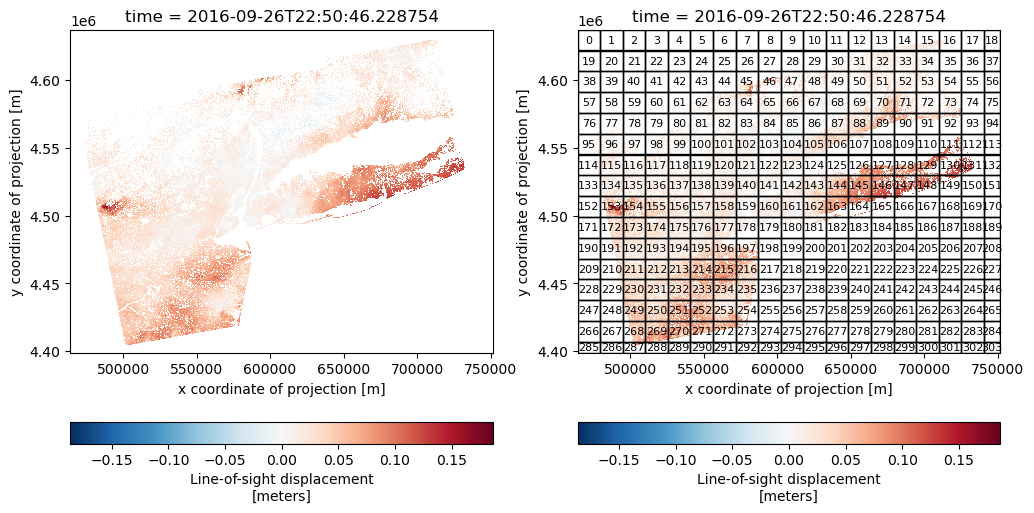

In [26]:
# Plot all chunks, take few min to plot chunk loc
# Skip this step if d
fig, ax = plt.subplots(1,2, figsize=(12,6))
cbar_kwargs={'orientation': 'horizontal'}

disp_epoch1_msk = stack.displacement.isel(time=0).where(stack.recommended_mask.isel(time=0)==1) 

disp_epoch1_msk.plot.imshow(ax=ax[0], cbar_kwargs=cbar_kwargs)
disp_epoch1_msk.plot.imshow(ax=ax[1], cbar_kwargs=cbar_kwargs)
for ix, block in enumerate(chunks_ix):
    plot_chunk_location(ax[1], stack, block, ix, zorder=1)

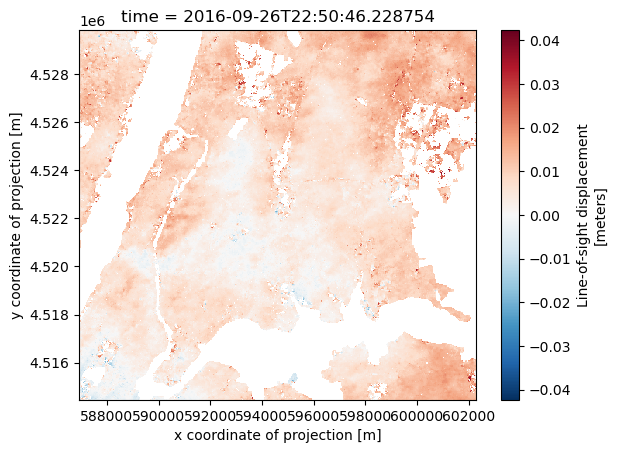

In [27]:
# Plot one chip for dev
ix = 141
mask = stack.recommended_mask[chunks_ix[ix]].isel(time=0)==1
stack.displacement[chunks_ix[ix]].isel(time=0).where(mask).plot.imshow()


In [28]:
small_stack = stack2.isel(y=chunks_ix[ix][1], x=chunks_ix[ix][2])

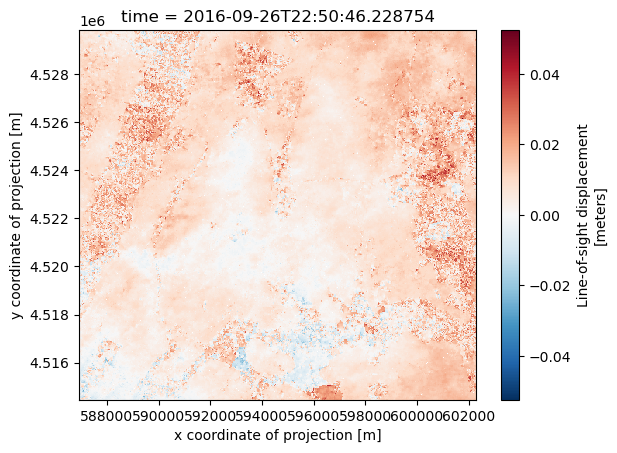

In [29]:
small_stack.displacement.isel(time=0).plot.imshow()

In [30]:
# Get stack quality metrics
pct_ps = quality_metrics.get_ps_percentage(small_stack)
pct_mask = quality_metrics.get_mask_percentage(small_stack) 
pct_conncomp = quality_metrics.get_conncomp_percentage(small_stack, reverse=True)
mean_tcoh = quality_metrics.get_mean_tcoh(small_stack)
mean_psim = quality_metrics.get_mean_phasesim(small_stack)
mean_pcor = quality_metrics.get_mean_phasecorr(small_stack)   

Get percentage of PS
Get percentage of PS


Get percentage of recommended mask
Get percentage of recommended mask
Get percentage of valid connected components
Get percentage of valid connected components
Get mean temporal coherence
Get mean temporal coherence
Get mean phase similarity
Get mean phase similarity
Get mean  estimated_phase_quality
Get mean  estimated_phase_quality


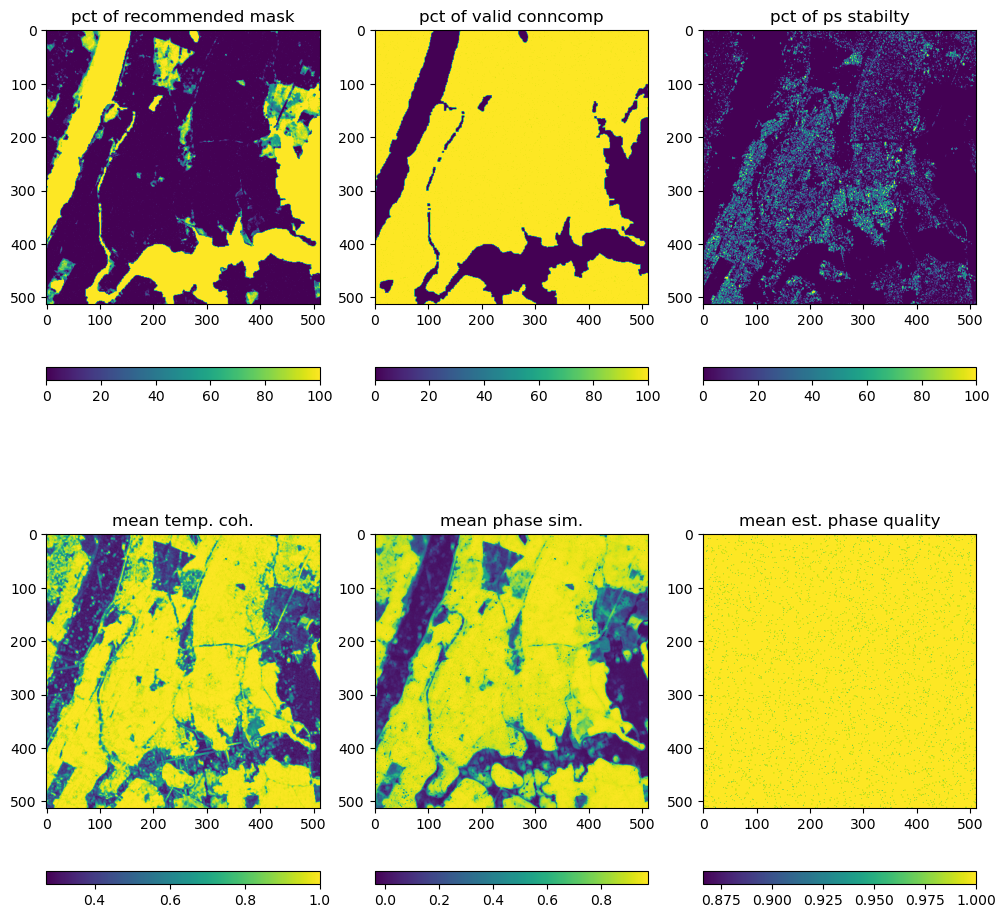

In [31]:
fig, axs = plt.subplots(2,3, figsize=(12,12))

txt = ['pct of recommended mask',
       'pct of valid conncomp',
       'pct of ps stabilty',
       'mean temp. coh.',
       'mean phase sim.',
       'mean est. phase quality']
vars = [pct_mask, pct_conncomp, pct_ps,
        mean_tcoh, mean_psim, mean_pcor]
im =[]
for ix, (t, v, ax) in enumerate(zip(txt, vars, axs.ravel())):
    im.append(ax.imshow(v))
    ax.set_title(t) 

for ax, i in zip(axs.ravel(), im):
    fig.colorbar(i, ax=ax, location='bottom')

NOTE: Take into account that phase_similarity, temporal coherence are estimated on ministack level
all epochs within a ministack, we have same value

In [32]:
# Explore other stats for temporal coherence
tcoh_stats = {}

for mode in ['mean', 'median', 'min', 'max', 'std', 'var']:
    tcoh_stats[mode] = quality_metrics.get_mean_tcoh(small_stack, mode)

Get mean temporal coherence
Get mean temporal coherence


Get median temporal coherence
Get median temporal coherence
Get min temporal coherence
Get min temporal coherence
Get max temporal coherence
Get max temporal coherence
Get std temporal coherence
Get std temporal coherence
Get var temporal coherence
Get var temporal coherence


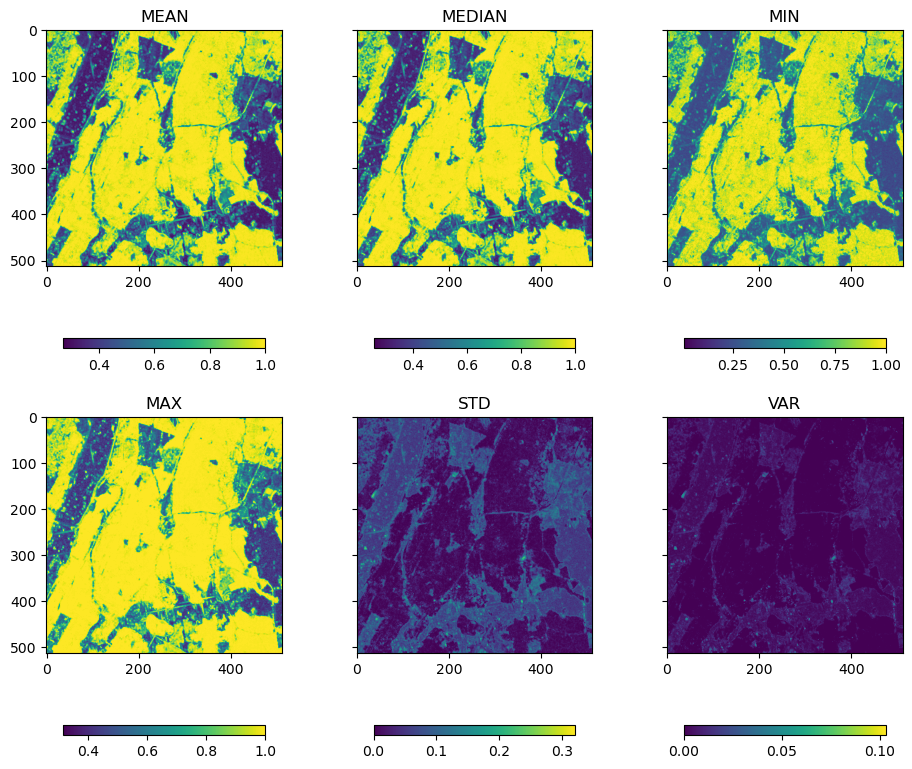

In [33]:
# PLOT
fig, axs = plt.subplots(2,3, figsize=(10,8), sharey=True)

for ax, (tcoh_key, tcoh_value) in zip(axs.ravel(), tcoh_stats.items()):
    im = (ax.imshow(tcoh_value))
    ax.set_title(tcoh_key.upper())
    fig.colorbar(im, ax=ax, location='bottom', pad=0.2, shrink=0.6)
plt.tight_layout()

Get mean shp count
Get mean shp count
Get median shp count
Get median shp count
Get min shp count
Get min shp count
Get max shp count
Get max shp count
Get std shp count
Get std shp count
Get var shp count
Get var shp count


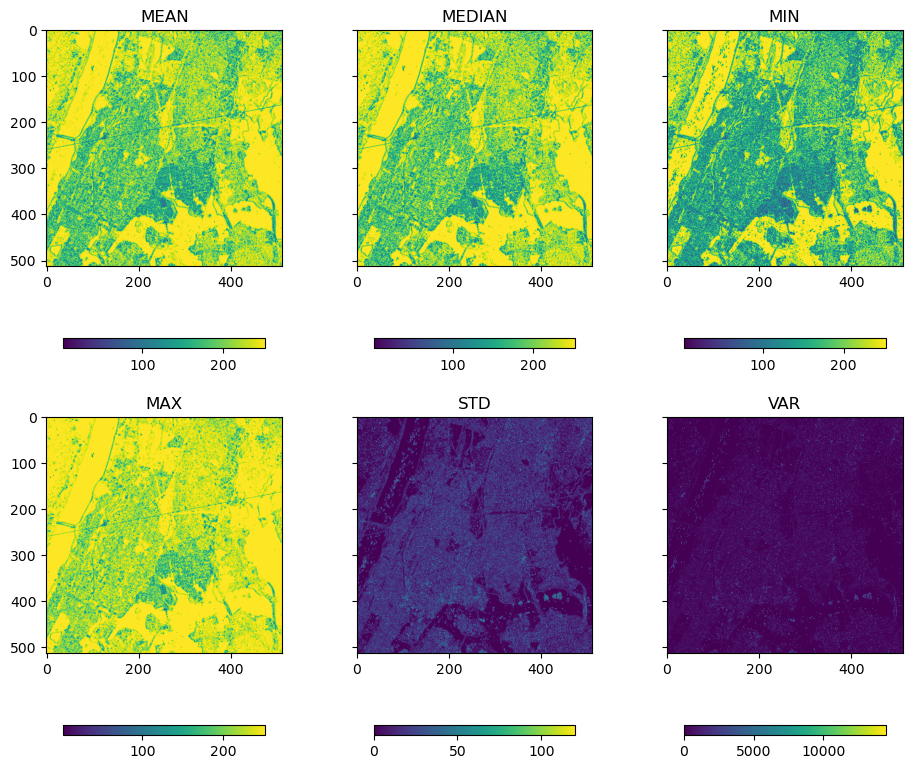

In [104]:
# Explore other stats for temporal coherence
shp_stats = {}

for mode in ['mean', 'median', 'min', 'max', 'std', 'var']:
    shp_stats[mode] = quality_metrics.get_mean_shpcount(small_stack, mode)

# PLOT
fig, axs = plt.subplots(2,3, figsize=(10,8), sharey=True)

for ax, (shp_key, shp_value) in zip(axs.ravel(), shp_stats.items()):
    im = (ax.imshow(shp_value))
    ax.set_title(shp_key.upper())
    fig.colorbar(im, ax=ax, location='bottom', pad=0.2, shrink=0.6)
plt.tight_layout()

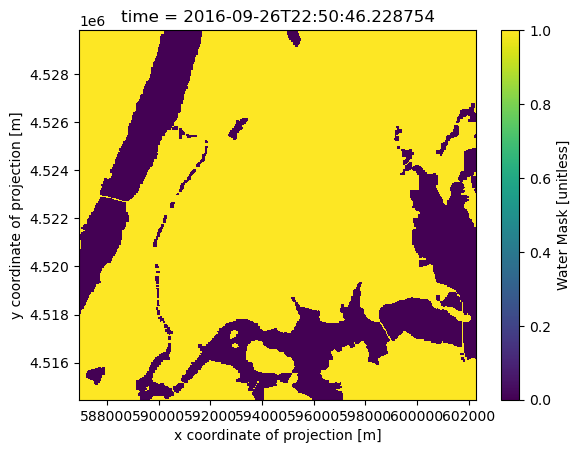

In [105]:
# Plot water mask
small_stack.isel(time=0).water_mask.plot.imshow()

To run it over full frame, use dask.Client to speed it up

# GET PHASE JUMPS

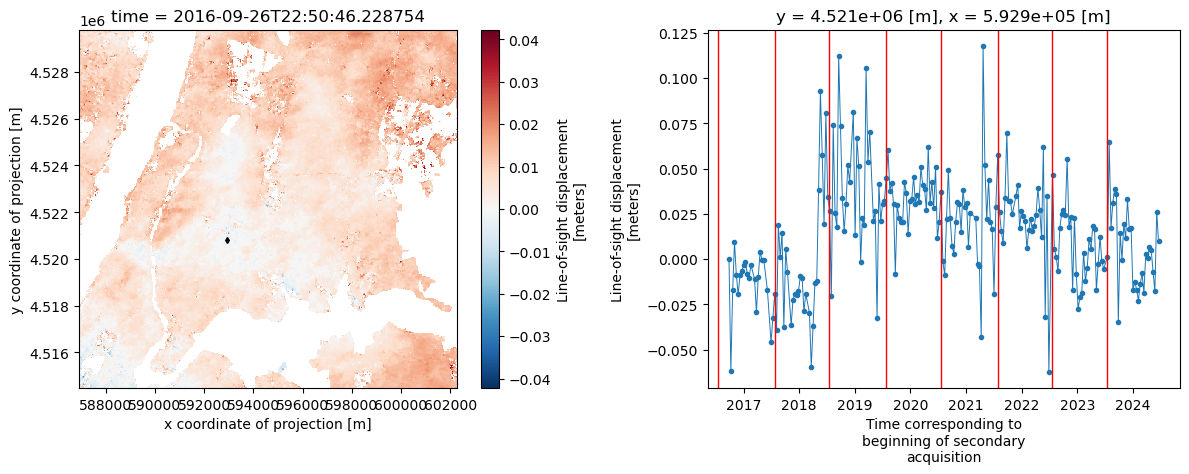

In [60]:
# REFERENCE POINT 300, 200
ref_dates = disp_xr.product._get_ministacks(disp_df)[1]
fig, ax = plt.subplots(1,2, figsize=(12,5))

mask = small_stack.recommended_mask.isel(time=0)==1
small_stack.displacement.isel(time=0).where(mask).plot.imshow(ax=ax[0])
ax[0].plot(small_stack.x.isel(x=200), small_stack.y.isel(y=300), 'kd', ms=3, zorder=1)

small_stack.isel(y=300,x=200).displacement.plot(ax=ax[1], marker='o', ms=3, lw=0.7)
for p in ref_dates: ax[1].axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)
plt.tight_layout()

In [61]:
from disp_xr.mintpy_utils.utils import find_reference_point 
# modify this function

In [62]:
y, x = find_reference_point(pct_mask, mean_tcoh, percentile=99)

Selected reference pixel (y/x): (311, 121)


/u/trappist-r0/govorcin/src/tools/conda/envs/insar2/lib/python3.11/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [63]:
def get_bounds(xr_data):
    x_min, x_max = xr_data.x.min().item(), xr_data.x.max().item()
    y_min, y_max = xr_data.y.min().item(), xr_data.y.max().item()
    return (x_min, x_max, y_min, y_max)


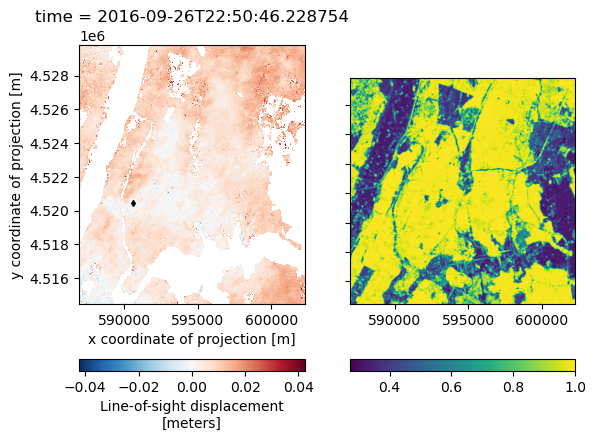

In [64]:
fig, ax = plt.subplots(1,2, sharey=True)
mask = small_stack.recommended_mask.isel(time=0) == 1
im = small_stack.displacement.isel(time=0).where(mask).plot.imshow(ax=ax[0],
                                                                   zorder=0,
                                    cbar_kwargs={'orientation': 'horizontal'})
ax[0].plot(small_stack.x.isel(x=x), small_stack.y.isel(y=y), 'kd', ms=3, zorder=1)
im=ax[1].imshow(mean_tcoh, extent=get_bounds(small_stack))
fig.colorbar(im, ax=ax[1], location='bottom')

In [65]:
ref_data = small_stack.isel(y=y, x=x).displacement

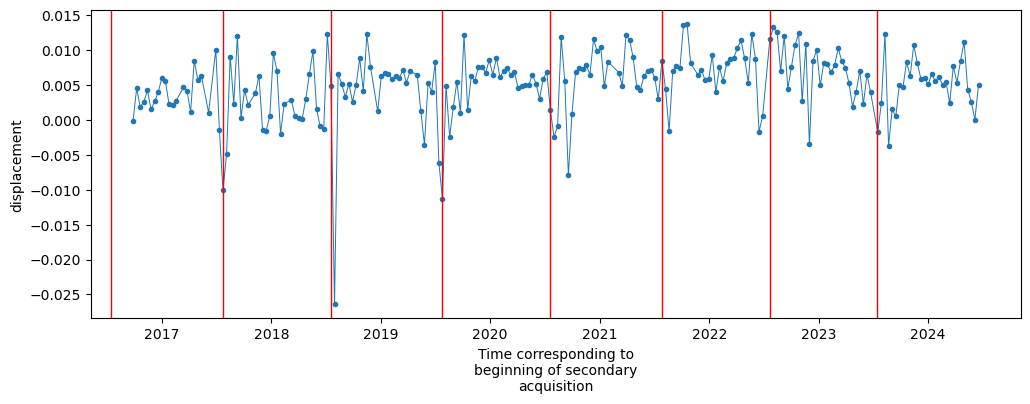

In [66]:
# Re-reference
fig, ax = plt.subplots(figsize=(12,4))
(small_stack.isel(y=300,x=200).displacement - ref_data).plot(ax=ax, marker='o', ms=3, lw=0.7)
for p in ref_dates: ax.axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)

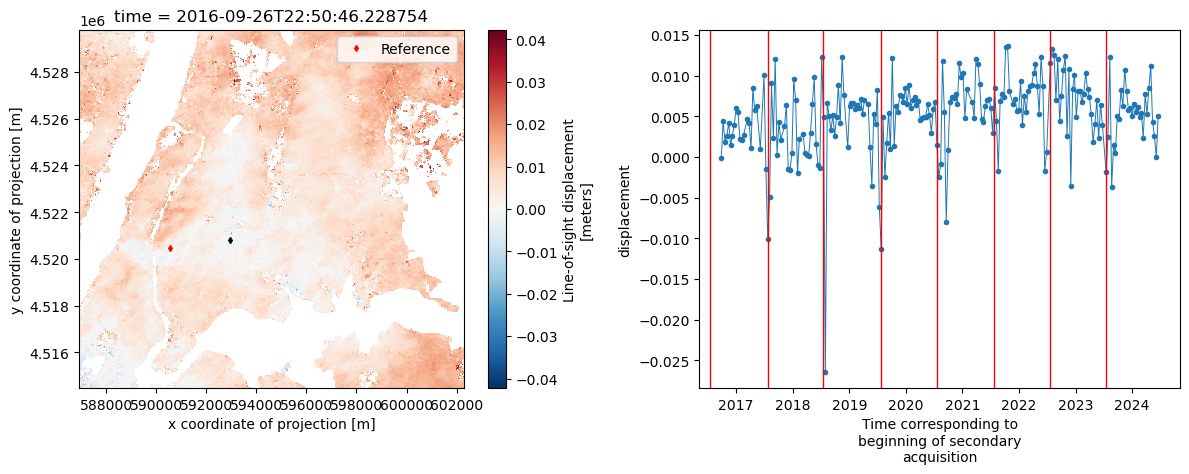

In [68]:
# REFERENCE POINT 300, 200
ref_dates = disp_xr.product._get_ministacks(disp_df)[1]
fig, ax = plt.subplots(1,2, figsize=(12,5))

mask = small_stack.recommended_mask.isel(time=0)==1
small_stack.displacement.isel(time=0).where(mask).plot.imshow(ax=ax[0])
ax[0].plot(small_stack.x.isel(x=200), small_stack.y.isel(y=300), 'kd', ms=3, zorder=1)
ax[0].plot(small_stack.x.isel(x=x), small_stack.y.isel(y=y), 'rd', ms=3, zorder=1, label='Reference')
ax[0].legend()

(small_stack.isel(y=300,x=200).displacement - ref_data).plot(ax=ax[1], marker='o', ms=3, lw=0.7)
for p in ref_dates: ax[1].axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)
plt.tight_layout()

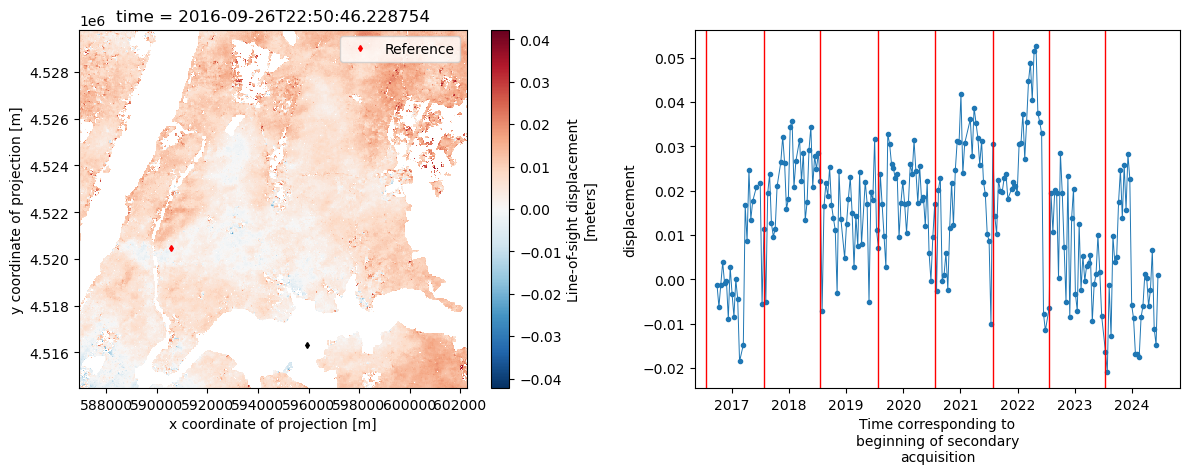

In [70]:
# REFERENCE POINT 450, 300
ref_dates = disp_xr.product._get_ministacks(disp_df)[1]
fig, ax = plt.subplots(1,2, figsize=(12,5))

mask = small_stack.recommended_mask.isel(time=0)==1
small_stack.displacement.isel(time=0).where(mask).plot.imshow(ax=ax[0])
ax[0].plot(small_stack.x.isel(x=300), small_stack.y.isel(y=450), 'kd', ms=3, zorder=1)
ax[0].plot(small_stack.x.isel(x=x), small_stack.y.isel(y=y), 'rd', ms=3, zorder=1, label='Reference')
ax[0].legend()

(small_stack.isel(y=450,x=300).displacement - ref_data).plot(ax=ax[1], marker='o', ms=3, lw=0.7)
for p in ref_dates: ax[1].axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)
plt.tight_layout()

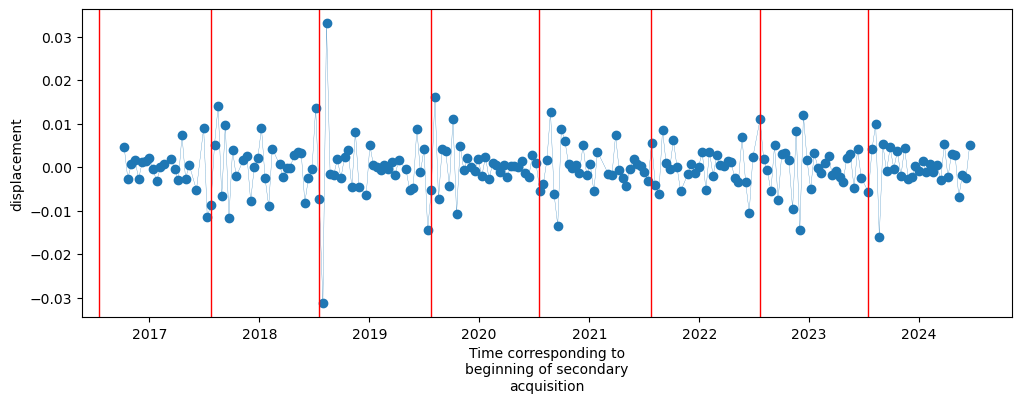

In [72]:
disp2phase = 4 * np.pi / 0.0566 
wrap = lambda x: np.mod((-4 *np.pi / 0.056 * x)+np.pi, 2*np.pi)-np.pi
wrap2pi = lambda x: np.mod((-4 *np.pi / 0.056 * x), 2*np.pi)

# Re-reference
re_referenced = small_stack.isel(y=300, x=200).displacement - ref_data
dif_data = re_referenced.diff(dim='time').values
dif_phase = dif_data * disp2phase

fig, ax = plt.subplots(figsize=(12,4))
re_referenced.diff(dim='time', label='upper').plot(ax=ax, marker='o', lw=0.2)
for p in ref_dates: ax.axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)

Text(0, 0.5, 'radian')

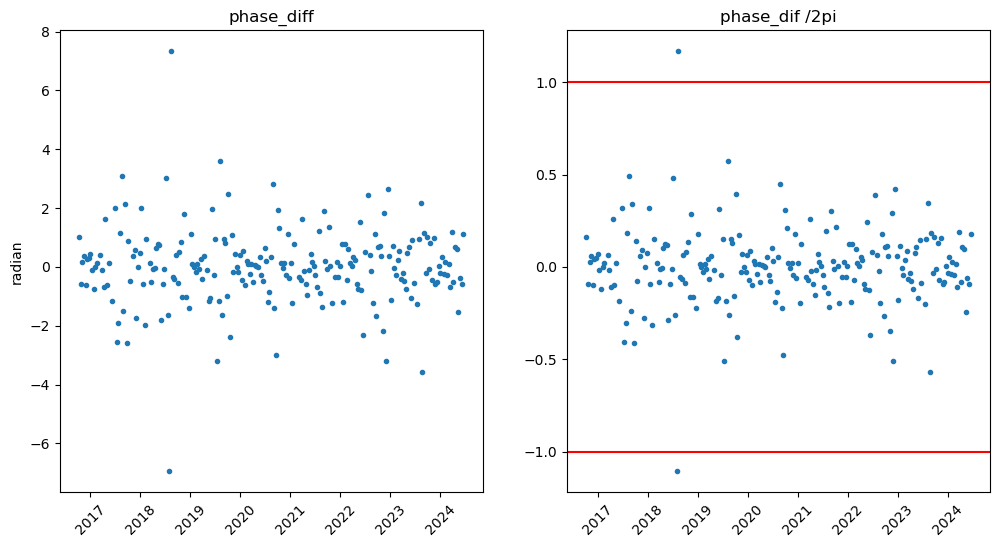

In [74]:
dt = re_referenced.diff(dim='time').time
fig, ax = plt.subplots(1,2, figsize=(12, 6))
for a, d in zip(ax, [dif_phase,
                     dif_phase / (2*np.pi)]):
    a.plot(dt, d, '.')

# Print color hline 2pi
ax[1].axhline(-1, color='red')
ax[1].axhline(1, color='red')

for a, t in zip(ax, ['phase_diff', 'phase_dif /2pi']):
    a.set_title(t)
    a.tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x-ticks

ax[0].set_ylabel('radian')

In [75]:
np.count_nonzero(np.abs(dif_phase / (2*np.pi))>1)

2

In [77]:
reference_block = np.tile(ref_data.values.reshape(-1, 1, 1),
                        (1, small_stack.sizes['y'], small_stack.sizes['x']))

In [78]:
jumps = np.abs(((small_stack.displacement - reference_block).diff(dim='time') * disp2phase) / (2*np.pi)) > 1

In [79]:
n_jumps = jumps.sum(dim='time').values

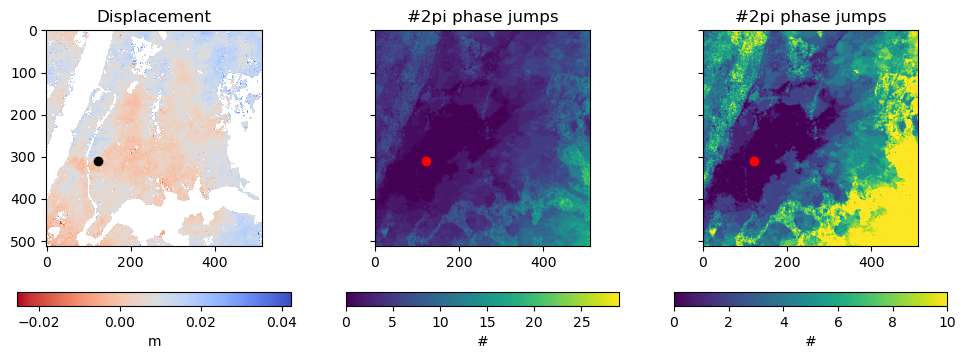

In [80]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12, 4))
im1 = ax[0].imshow(small_stack.displacement.isel(time=0).where(mask).values, 
                   cmap='coolwarm_r', interpolation='nearest')
im2 = ax[1].imshow(n_jumps)
im3 = ax[2].imshow(n_jumps, clim=(0,10))
for a in ax[1:]: a.plot(x,y, 'ro'), a.set_title('#2pi phase jumps')
ax[0].plot(x,y, 'ko')
ax[0].set_title('Displacement')
fig.colorbar(im1, ax=ax[0], location='bottom', label='m')
fig.colorbar(im2, ax=ax[1], location='bottom', label='#')
fig.colorbar(im3, ax=ax[2], location='bottom', label='#')

In [83]:
jump2pi = (((small_stack.displacement - reference_block).diff(dim='time') * disp2phase) / (2*np.pi)).values

# Define window size
window_size = 2

# Create moving windows
windows = np.lib.stride_tricks.sliding_window_view(jump2pi, window_size, axis=0)

# Compute the moving average
moving_median = np.median(windows, axis=-1)

(-0.025, 0.025)

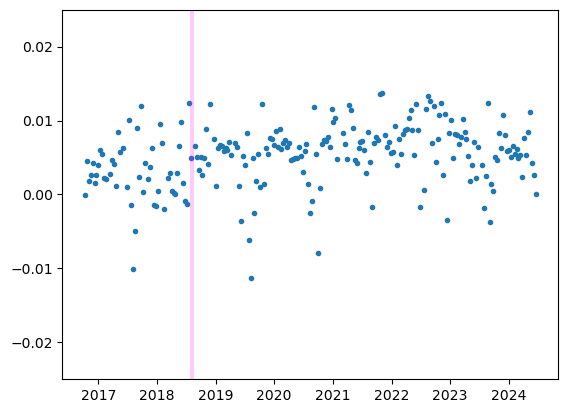

In [86]:
plt.plot(dt,(small_stack.displacement - reference_block).isel(time=slice(0, -1), y=300,x=200), '.')
plt.vlines(dt[np.squeeze(np.argwhere(np.abs(jump2pi[:,300,200]) > 1))], -0.1,0.1, color='magenta', linewidth=0.3)
plt.ylim([-0.025,0.025])

In [87]:
ix = 300
iy = 300

In [92]:
def plot_profile(ax, mov_median, ix, iy):
    demedian = mov_median[:, iy,ix] - np.median(mov_median[:, iy,ix])
    ax.plot(demedian, marker='.', lw=0)
    ax.axhline(np.median(mov_median[:, iy,ix]) - np.std(mov_median[:, iy,ix]), color='red')
    ax.axhline(np.median(mov_median[:, iy,ix]) + np.std(mov_median[:, iy,ix]), color='red')


Text(0.5, 1.0, 'Median of rolling window through 2pi jumps')

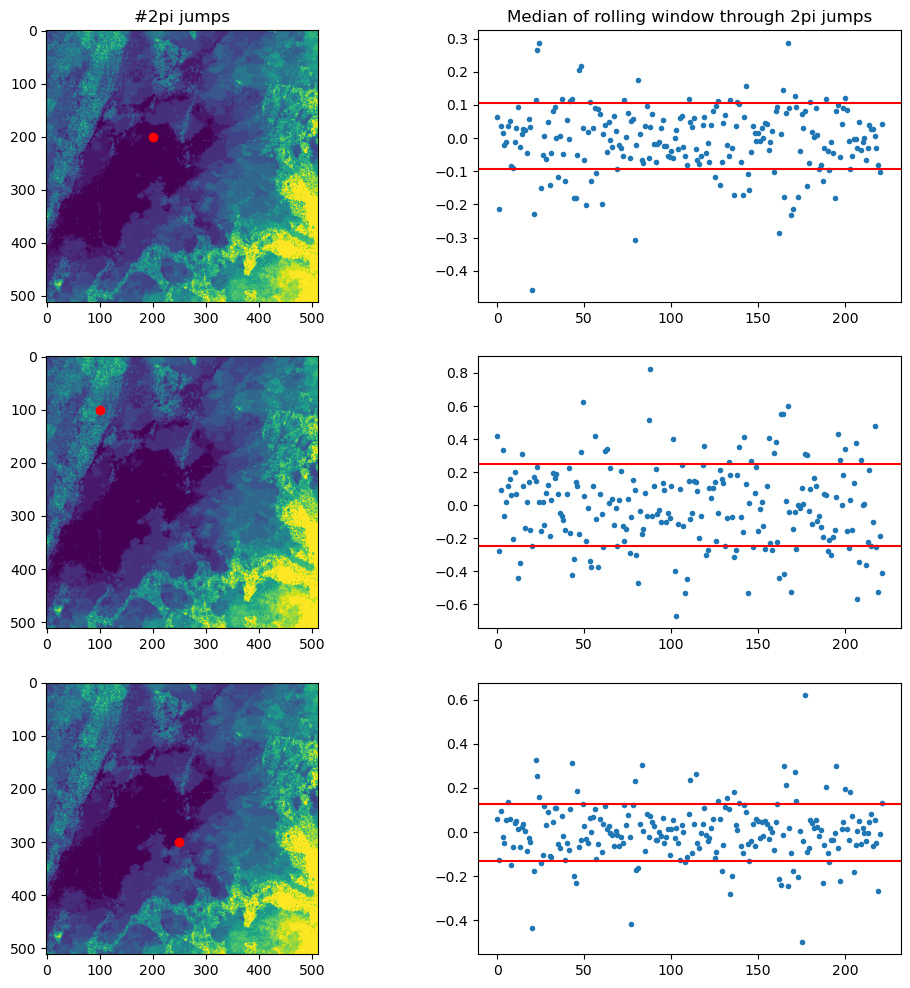

In [93]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
ax[0,0].imshow(n_jumps, clim=(0,15))
ax[1,0].imshow(n_jumps, clim=(0,15))
ax[2,0].imshow(n_jumps, clim=(0,15))
ax[0,0].plot(200,200, 'ro')
ax[1,0].plot(100,100, 'ro')
ax[2,0].plot(250,300, 'ro')
plot_profile(ax[0,1], moving_median, 200, 200)
plot_profile(ax[1,1], moving_median, 100, 100)
plot_profile(ax[2,1], moving_median, 300, 250)

ax[0,0].set_title('#2pi jumps')
ax[0,1].set_title('Median of rolling window through 2pi jumps')

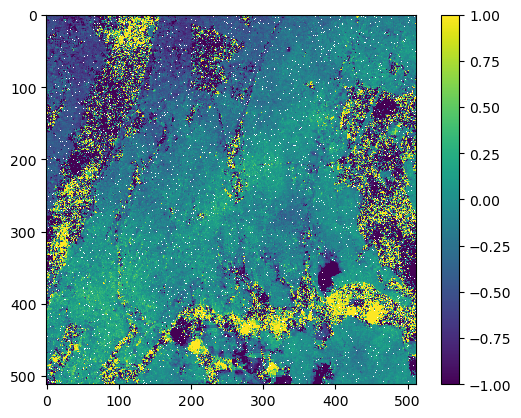

In [94]:
plt.imshow(np.sum(moving_median, axis=0) - np.median(moving_median, axis=0), interpolation='nearest', clim=[-1,1])
plt.colorbar()